In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import functools as ft
from scipy import interpolate

# Set some formatting parameters for matplotlib parameters
matplotlib.rcParams.update({'font.size': 16})  # Font size
matplotlib.rc('text', usetex=True)             # Use Latex formatting for text
matplotlib.rc('font',family='Times New Roman') # Use Times New Roman font

In [2]:
# Create a list of years for which I have data
# Have data from 1990 until 2024
years_of_data = np.arange(1990,2025,1)

print(years_of_data)
n_years = len(years_of_data)

[1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003
 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
 2018 2019 2020 2021 2022 2023 2024]


**Read in the available data**

In [3]:
# Read in LEGO set data
lego_df = pd.read_pickle('data/Lego_data.pkl')

**Add columns of data for the price per piece and price per weight**

In [4]:
# Add in columns of data for the price per piece for AU, US, UK and Germany (Euro)
lego_df['AU_PPP'] = lego_df['AURetailPrice']/lego_df['Pieces']
lego_df['US_PPP'] = lego_df['USRetailPrice']/lego_df['Pieces']
lego_df['UK_PPP'] = lego_df['UKRetailPrice']/lego_df['Pieces']
lego_df['DE_PPP'] = lego_df['DERetailPrice']/lego_df['Pieces']

# Add in columns of data for the price per weight for AU, US, UK and Germany (Euro)
lego_df['AU_PPW'] = lego_df['AURetailPrice']/lego_df['Weight (in Grams)']
lego_df['US_PPW'] = lego_df['USRetailPrice']/lego_df['Weight (in Grams)']
lego_df['UK_PPW'] = lego_df['UKRetailPrice']/lego_df['Weight (in Grams)']
lego_df['DE_PPW'] = lego_df['DERetailPrice']/lego_df['Weight (in Grams)']

**Read in historical median salary and exchange rate information from various sources**

In [5]:
# Read in Australian median weekly salary from the ABS
df_salary_AU = pd.read_csv("data/median_weekly_salary_AU.csv",
                       names=['Year','Weekly Salary'])

median_AU_salary = df_salary_AU['Weekly Salary'].values.tolist()

# Read in US median weekly salary from the US Bureau of Labor Statistics
df_salary_US = pd.read_csv("data/median_weekly_salary_US.csv")

# Information is available quarterly for the year, so convert to an annual value by averaging over the 4 quarters
mean_US_salary = df_salary_US.groupby(df_salary_US.index//4)['Value'].mean()
mean_US_salary = mean_US_salary.values.tolist()

# Read in UK median weekly salary from the office of national statistics
UK_salary_data = pd.read_csv("data/median_weekly_salary_UK.csv", sep='\t',
                            names=['Month','Value'])

# Data is provided per month, so average over a 12 month period to obtain an estimate of the annual value
mean_UK_salary = UK_salary_data.groupby(UK_salary_data.index//12)['Value'].mean()

# Read in the German median salary data from the German stats website
German_salary_data = pd.read_csv("data/median_monthly_salary_GER.csv",
                            names=['Year','Value'])

# Data is provided per month, so multiply by 12 and divide by 52 to convert it into a weekly estimate
mean_German_salary = np.array(German_salary_data['Value'].values.tolist())
mean_German_salary *= 12./52.

# Historical yearly averaged exchange rates (obtained from OFX)
df_exchange = pd.read_csv("data/annual_exchange_rates.csv",
                       names=['Year','AUD_to_US','AUD_to_Euro','AUD_to_UK'])

**Create subsets of data for the PPP and PPW over the past 3 years (2022 - 2024)**

In [6]:
# Create a dataframe of all LEGO sets for the past 3 years
select_data_3yrs = lego_df[(lego_df['YearFrom'] >= 2022) & (lego_df['YearFrom'] <= 2024)].copy()

# Create a separate subset of LEGO sets for the past 3 years excluding various themes
# that may skew the parts per piece (i.e. large numbers of 1x1 studs decreasing the PPP from the mean)
select_data_3yrs_limited = lego_df[(lego_df['YearFrom'] >= 2022) & (lego_df['YearFrom'] <= 2024)
                                    & (lego_df['Theme'] != 'Art') & (lego_df['Theme'] != 'Dots')
                                    & (lego_df['Theme'] != 'Technic')].copy()

**Determine PPP and PPW information as a function of calendar year**

Here, we want to investigate how our two metrics, PPP and PPW vary as a function of year that the LEGO sets were released. Therefore, split the data by year and determine the information. Do this for all four currencies that I will be considering (e.g. Australian, US, UK and Germany).

In [7]:
# Numpy arrays to hold information for the mean and median PPP and PPW for the Australian economy
# Two indices, PPP (0) and PPW (1)
au_pp_mean_all = np.zeros((2,n_years))
au_pp_median_all = np.zeros((2,n_years))

# Numpy arrays to hold the median PPP, PPW and RetailPrice per economy
# Three indices, PPP (0), PPW (1) and RetailPrice (2)
au_median_all = np.zeros((3,n_years)) # For Australia
us_median_all = np.zeros((3,n_years)) # For US
uk_median_all = np.zeros((3,n_years)) # For UK
eu_median_all = np.zeros((3,n_years)) # For Europe (Germany)

# Loop over all available years of data
for i_year in range(n_years):    
    # Obtain a data frame for the current year
    set_scatter_yr = lego_df[lego_df['YearFrom'] == years_of_data[i_year]].copy()

    # Calculate the mean of the PPP and PPW for the Australian dollar
    au_pp_mean_all[0][i_year] = np.mean(set_scatter_yr['AU_PPP'].values.tolist())
    au_pp_mean_all[1][i_year] = np.mean(set_scatter_yr['AU_PPW'].values.tolist())

    # Calculate the median of the PPP and PPW for the Australian dollar
    au_pp_median_all[0][i_year] = np.median(set_scatter_yr['AU_PPP'].values.tolist())
    au_pp_median_all[1][i_year] = np.median(set_scatter_yr['AU_PPW'].values.tolist())

    # Calculate the median of the number of pieces in a set, weight in grams and retail price (Australian dollar)
    au_median_all[0][i_year] = np.median(set_scatter_yr['Pieces'].values.tolist())
    au_median_all[1][i_year] = np.median(set_scatter_yr['Weight (in Grams)'].values.tolist())
    au_median_all[2][i_year] = np.median(set_scatter_yr['AURetailPrice'].values.tolist())    

    # Calculate the median of the number of pieces in a set, weight in grams and retail price (US dollar)
    us_median_all[2][i_year] = np.nanmedian(np.array(set_scatter_yr['USRetailPrice'].values.tolist()))
    us_median_all[0][i_year] = np.nanmedian(np.array(set_scatter_yr['US_PPP'].values.tolist()))
    us_median_all[1][i_year] = np.nanmedian(np.array(set_scatter_yr['US_PPW'].values.tolist()))
    
    # Calculate the median of the number of pieces in a set, weight in grams and retail price (UK pound)
    uk_median_all[2][i_year] = np.nanmedian(np.array(set_scatter_yr['UKRetailPrice'].values.tolist()))
    uk_median_all[0][i_year] = np.nanmedian(np.array(set_scatter_yr['UK_PPP'].values.tolist()))
    uk_median_all[1][i_year] = np.nanmedian(np.array(set_scatter_yr['UK_PPW'].values.tolist()))

    # Calculate the median of the number of pieces in a set, weight in grams and retail price (Euro)
    eu_median_all[2][i_year] = np.nanmedian(np.array(set_scatter_yr['DERetailPrice'].values.tolist()))
    eu_median_all[0][i_year] = np.nanmedian(np.array(set_scatter_yr['DE_PPP'].values.tolist()))
    eu_median_all[1][i_year] = np.nanmedian(np.array(set_scatter_yr['DE_PPW'].values.tolist()))    

/var/folders/d0/2tht3d796tlbs6k234bnkgxc0000gn/T/ipykernel_72082/1782453851.py:37: RuntimeWarning: All-NaN slice encountered
  uk_median_all[2][i_year] = np.nanmedian(np.array(set_scatter_yr['UKRetailPrice'].values.tolist()))
/var/folders/d0/2tht3d796tlbs6k234bnkgxc0000gn/T/ipykernel_72082/1782453851.py:38: RuntimeWarning: All-NaN slice encountered
  uk_median_all[0][i_year] = np.nanmedian(np.array(set_scatter_yr['UK_PPP'].values.tolist()))
/var/folders/d0/2tht3d796tlbs6k234bnkgxc0000gn/T/ipykernel_72082/1782453851.py:39: RuntimeWarning: All-NaN slice encountered
  uk_median_all[1][i_year] = np.nanmedian(np.array(set_scatter_yr['UK_PPW'].values.tolist()))
/var/folders/d0/2tht3d796tlbs6k234bnkgxc0000gn/T/ipykernel_72082/1782453851.py:42: RuntimeWarning: All-NaN slice encountered
  eu_median_all[2][i_year] = np.nanmedian(np.array(set_scatter_yr['DERetailPrice'].values.tolist()))
/var/folders/d0/2tht3d796tlbs6k234bnkgxc0000gn/T/ipykernel_72082/1782453851.py:43: RuntimeWarning: All-NaN sli

**Plot the price per piece (PPP) as a function of country currency**

Compare the price per piece (PPP) metric as a function of cost in that country. This uses the set retail price in the given country and the corresponding median salary. As it is a ratio of two values with units of currency, no conversion is needed between the various currencies.

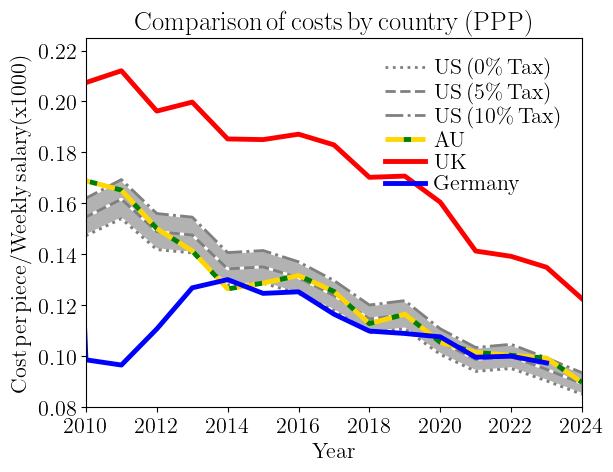

In [8]:
# Empty lists to contain line and handle information for the legend
label_panel = []
handles_panel = []

# Draw a shaded region encompassing 0 - 10% sales tax for the PPP for the US
plt.fill_between(years_of_data,1000.*us_median_all[0]/mean_US_salary,1000.*1.1*us_median_all[0]/mean_US_salary,color='gray',alpha=0.6)

# Draw a grey dotted line to denote the region corresponding to 0% sales tax in the US for the PPP
lines_d1, = plt.plot(years_of_data,1000.*us_median_all[0]/mean_US_salary,color='gray',linewidth=2,linestyle='dotted',gapcolor='white')
# Label for 0% sales tax in the US
label_panel.append(r"${\rm US\,(0\% \,Tax)}$")
# Line information for the legend
handles_panel.append((lines_d1,))

# Draw a grey dashed line to denote the region corresponding to 5% sales tax in the US for the PPP
lines_d1, = plt.plot(years_of_data,1000.*1.05*us_median_all[0]/mean_US_salary,color='gray',linewidth=2,linestyle='dashed',gapcolor='white')
# Label for 5% sales tax in the US
label_panel.append(r"${\rm US\,(5\% \,Tax)}$")
# Line information for the legend
handles_panel.append((lines_d1,))

# Draw a grey dash dot line to denote the region corresponding to 10% sales tax in the US for the PPP
lines_d1, = plt.plot(years_of_data,1000.*1.1*us_median_all[0]/mean_US_salary,color='gray',linewidth=2,linestyle='dashdot',gapcolor='white')
# Label for 10% sales tax in the US
label_panel.append(r"${\rm US\,(10\% \,Tax)}$")
# Line information for the legend
handles_panel.append((lines_d1,))

# Draw a green and gold dashed line to denote the PPP for Australia
lines_d1, = plt.plot(years_of_data,1000.*au_pp_median_all[0]/median_AU_salary,linestyle='dashed',color='gold',gapcolor='green',linewidth=3.5)
# Label for AU dollar
label_panel.append(r"${\rm AU}$")
# Line information for the legend
handles_panel.append((lines_d1,))

# Draw a red line to denote the PPP for the UK
lines_d1, = plt.plot(years_of_data,1000.*uk_median_all[0]/mean_UK_salary,color='red',linewidth=3.5)
# Label for UK pound
label_panel.append(r"${\rm UK}$")
# Line information for the legend
handles_panel.append((lines_d1,))

# Draw a blue line to denote the PPP for Europe (Germany)
lines_d1, = plt.plot(years_of_data[1:-1],1000.*eu_median_all[0][1:-1]/mean_German_salary,color='blue',linewidth=3.5)
# Label for Euro (Germany)
label_panel.append(r"${\rm Germany}$")
# Line information for the legend
handles_panel.append((lines_d1,))

# Set the x and y values for the figure
plt.xlim(2010,2024)
plt.ylim(1000.*0.00008,1000.*0.000225)

# Draw the legend for this figure
plt.legend(handles_panel, label_panel,loc=1, frameon=False, handlelength = 1.8, handletextpad=0.4, labelspacing=0.1)

# Labels for the x, y and title of the figure
plt.xlabel(r"${\rm Year}$")
plt.ylabel(r"${\rm Cost\,per\,piece / Weekly\,salary (x1000)}$")
plt.title(r"${\rm Comparison\,of\,costs\,by\,country\,(PPP)}$")
plt.savefig("Country_cost_PPP.png",dpi=300)

**Plot the price per weight (PPW) as a function of country currency**

Compare the price per weight (PPW) metric as a function of cost in that country. This uses the set retail price in the given country and the corresponding median salary. As it is a ratio of two values with units of currency, no conversion is needed between the various currencies.

For the US, since sales tax differs by state, I provide a shaded region spanning 0 - 10% sales tax.

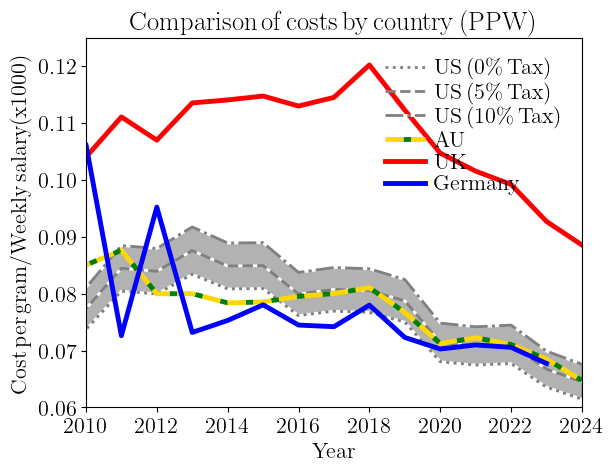

In [9]:
# Empty lists to contain line and handle information for the legend
label_panel = []
handles_panel = []

# Draw a shaded region encompassing 0 - 10% sales tax for the PPW for the US
plt.fill_between(years_of_data,1000.*us_median_all[1]/mean_US_salary,1000.*1.1*us_median_all[1]/mean_US_salary,color='gray',alpha=0.6)

# Draw a grey dotted line to denote the region corresponding to 0% sales tax in the US for the PPW
lines_d1, = plt.plot(years_of_data,1000.*us_median_all[1]/mean_US_salary,color='gray',linewidth=2,linestyle='dotted',gapcolor='white')
# Label for 0% sales tax in the US
label_panel.append(r"${\rm US\,(0\% \,Tax)}$")
# Line information for the legend
handles_panel.append((lines_d1,))

# Draw a grey dashed line to denote the region corresponding to 5% sales tax in the US for the PPW
lines_d1, = plt.plot(years_of_data,1000.*1.05*us_median_all[1]/mean_US_salary,color='gray',linewidth=2,linestyle='dashed',gapcolor='white')
# Label for 5% sales tax in the US
label_panel.append(r"${\rm US\,(5\% \,Tax)}$")
# Line information for the legend
handles_panel.append((lines_d1,))

# Draw a grey dash dot line to denote the region corresponding to 10% sales tax in the US for the PPW
lines_d1, = plt.plot(years_of_data,1000.*1.1*us_median_all[1]/mean_US_salary,color='gray',linewidth=2,linestyle='dashdot',gapcolor='white')
# Label for 10% sales tax in the US
label_panel.append(r"${\rm US\,(10\% \,Tax)}$")
# Line information for the legend
handles_panel.append((lines_d1,))

# Draw a green and gold dashed line to denote the PPW for Australia
lines_d1, = plt.plot(years_of_data,1000.*au_pp_median_all[1]/median_AU_salary,linestyle='dashed',color='gold',gapcolor='green',linewidth=3.5)
# Label for AU dollar
label_panel.append(r"${\rm AU}$")
# Line information for the legend
handles_panel.append((lines_d1,))

# Draw a red line to denote the PPW for the UK
lines_d1, = plt.plot(years_of_data,1000.*uk_median_all[1]/mean_UK_salary,color='red',linewidth=3.5)
# Label for UK pound
label_panel.append(r"${\rm UK}$")
# Line information for the legend
handles_panel.append((lines_d1,))

# Draw a blue line to denote the PPW for Europe (Germany)
lines_d1, = plt.plot(years_of_data[1:-1],1000.*eu_median_all[1][1:-1]/mean_German_salary,color='blue',linewidth=3.5)
# Label for Euro (Germany)
label_panel.append(r"${\rm Germany}$")
# Line information for the legend
handles_panel.append((lines_d1,))

# Set the x and y values for the figure
plt.xlim(2010,2024)
plt.ylim(1000.*0.00006,1000.*0.000125)

# Draw the legend for this figure
plt.legend(handles_panel, label_panel,loc=1, frameon=False, handlelength = 1.8, handletextpad=0.4, labelspacing=0.1)

# Labels for the x, y and title of the figure
plt.xlabel(r"${\rm Year}$")
plt.ylabel(r"${\rm Cost\,per\,gram / Weekly\,salary (x1000)}$")
plt.title(r"${\rm Comparison\,of\,costs\,by\,country\,(PPW)}$")
plt.savefig("Country_cost_PPW.png",dpi=300)